# オルツ ５分足

In [1]:
import sys

sys.path.append("..")

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r"(.+)\.T")

symbol = "260A.T"
ticker = yf.Ticker(symbol)

df = ticker.history(period="1d", interval="5m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-05-01 10:05:00+09:00,113.0,117.0,112.0,115.0,0,0.0,0.0
2025-05-01 10:10:00+09:00,115.0,118.0,110.0,117.0,6610000,0.0,0.0
2025-05-01 10:15:00+09:00,117.0,122.0,115.0,120.0,3787400,0.0,0.0
2025-05-01 10:20:00+09:00,120.0,140.0,120.0,137.0,8782400,0.0,0.0
2025-05-01 10:25:00+09:00,138.0,138.0,123.0,124.0,5003900,0.0,0.0
2025-05-01 10:30:00+09:00,124.0,125.0,118.0,123.0,3357400,0.0,0.0
2025-05-01 10:35:00+09:00,122.0,124.0,118.0,119.0,950600,0.0,0.0
2025-05-01 10:40:00+09:00,119.0,121.0,118.0,119.0,1205400,0.0,0.0
2025-05-01 10:45:00+09:00,119.0,122.0,113.0,113.0,1856900,0.0,0.0


## ローソク足チャートとパラボリック SAR

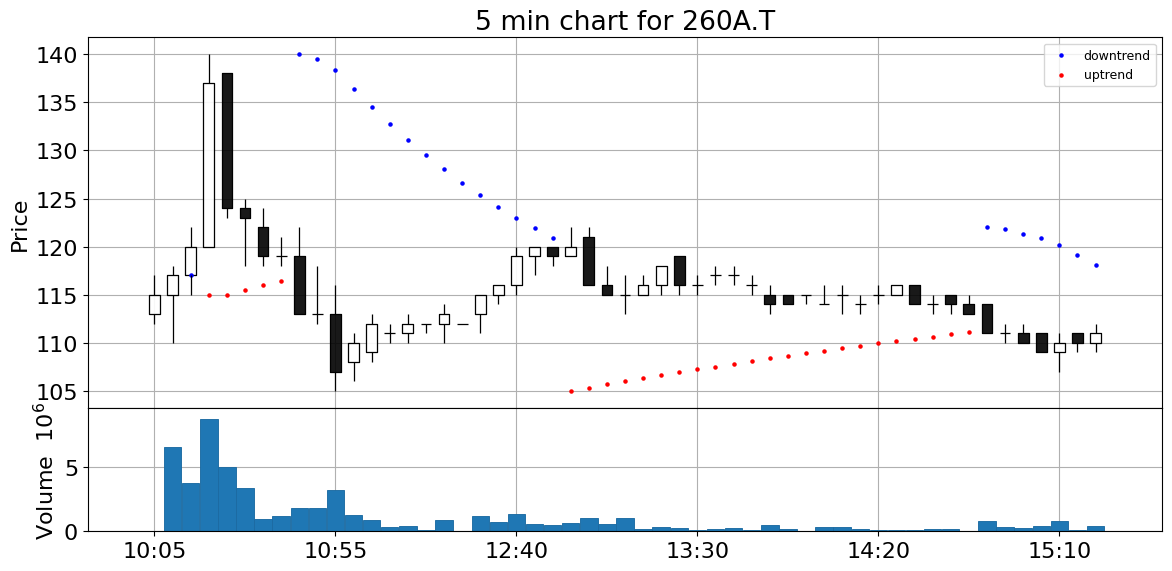

In [3]:
dict_psar = psar(df)

plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_subplot(111)
gs = fig.add_gridspec(
    2, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3, 1]
)

ax = dict()
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    datetime_format='%H:%M',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
    volume=ax[1],
)

try:
    ax[0].set_title('5 min chart for %s (%s)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('5 min chart for %s' % symbol)

ax[0].grid()
ax[0].legend(loc='best', fontsize=9)

ax[1].grid()


plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('5min_chart_%s.png' % m.group(1))
else:
    plt.savefig('5min_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Datetime
2025-03-05 09:00:00+09:00    566.0
2025-03-05 09:05:00+09:00    566.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Datetime
2025-03-05 09:00:00+09:00    NaN
2025-03-05 09:05:00+09:00    0.0
Name: Close, dtype: float64